# Разведочный анализ данных и разметка

### Шаг 0: Подготовка
1. Поскольку коммерческие данные получить быстро не удалось, было принято решение использовать публичные данные, доступные на [госзакупках](https://zakupki.gov.ru/epz/main/public/home.html).
2. В связи с таким изменением подхода появилась необходимость переформулирования задачи, теперь она сформулирована так: "Классификация договора в зависимости от предмета по второму уровню ОКПД2". Классификатор ОКПД2 можно получить, например, [здесь](https://www.consultant.ru/document/cons_doc_LAW_163703/). Таким образом, цель изменилась до: по разделу предмета договора вернуть второй уровень кода ОКПД2.
Важное замечание: поскольку предметов договора в данном случае может быть много, то мы имеем дело с многоклассовой классификацией.
3. Датасет состоит из 199913 записей в формате JSON, содержащие три поля "regNum" - реестровый номер контракта, "contractSubjectFull" - полный текст предмета договора, "OKPD2_codes" - набор ОКПД2 кодов из договора. Датасет расположени по [адресу](https://www.kaggle.com/datasets/aldarovalexander/contract). Сам датасет был получен путем парсинга части исполненных договоров за 2022 год, которые бы имели формат верный DOCX и разбора формализованной части договоров. Часть процесса получения, например, из графического представления договора верного текста предмета в данном исследовании опущена, поскольку для целей самого исследования не представляет интереса.
4. Блокнот доступен в [колабе](https://colab.research.google.com/github/aldarovav/YearProject/blob/main/analysis.ipynb)


### Шаг 1: Импорт библиотек и настройка

In [64]:
!pip install pymorphy3
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 46.1 MB/s eta 0:00:0000:0100:01


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os
import io
import requests
import json
import kagglehub
import pymorphy3
import nltk
import matplotlib.pyplot as plt

from io import StringIO
from collections import Counter

# Настройка отображения
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Библиотеки загружены")
print("Текущая рабочая директория:", os.getcwd())

Библиотеки загружены
Текущая рабочая директория: /content


### Шаг 2: Загрузка и первичный анализ данных

In [ ]:
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Указываем конкретный файл для загрузки
file_path = "contracts_dataset_unique.json"

# Сначала получим путь к файлу
dataset_path = kagglehub.dataset_download("aldarovalexander/contract")
full_file_path = f"{dataset_path}/{file_path}"

# Загрузим JSON с указанием dtype - это необходимо, поскольку иначе read_json воспринимает regNum как число и обрезает его, что создает неуникальные записи
df = pd.read_json(full_file_path, dtype={'regNum': str})


100%|██████████| 23.9M/23.9M [00:00<00:00, 136MB/s] 

Extracting files...


First 5 records:                 regNum  \
0  0166300031414000004   
1  0324300007314000014   
2  0366300032914000027   
3  1010501417722000033   
4  1010501746721000017   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [8]:

# Посмотрим первые записи
print("Первые 5 записей:", df.head(5))

Первые 5 записей:                 regNum  \
0  0166300031414000004   
1  0324300007314000014   
2  0366300032914000027   
3  1010501417722000033   
4  1010501746721000017   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [9]:
# Первичный анализ
print(f"Размер датасета: {df.shape}")
print(f"Колонки: {list(df.columns)}")
print("\nТипы данных:")
print(df.dtypes)


Размер датасета: (199913, 3)
Колонки: ['regNum', 'contractSubjectFull', 'OKPD2_codes']

Типы данных:
regNum                 object
contractSubjectFull    object
OKPD2_codes            object
dtype: object


In [11]:
# Более детальный анализ
print(f"Общее количество записей: {len(df)}")
print(f"Количество уникальных номеров контрактов: {df['regNum'].nunique()}")
print(f"Неуникальные номера контрактов: {df[df.duplicated('regNum', keep=False)]}")


Общее количество записей: 199913
Количество уникальных номеров контрактов: 199913
Неуникальные номера контрактов: Empty DataFrame
Columns: [regNum, contractSubjectFull, OKPD2_codes]
Index: []


Очень хороший результат - все записи уникальны

In [ ]:
# Правильный анализ ОКПД кодов (списков)
all_okpd2_codes = df['OKPD2_codes'].explode() # Развернем списки ОКПД2 кодов для анализа
print(f"Всего ОКПД2 кодов (с повторениями): {len(all_okpd2_codes)}")
print(f"Уникальных ОКПД2 кодов: {all_okpd2_codes.nunique()}")
top_10_okpd2 = all_okpd2_codes.value_counts().head(10)
print(f"Топ-10 самых частых ОКПД2 кодов: {top_10_okpd2}")

Всего ОКПД2 кодов (с повторениями): 211887
Уникальных ОКПД2 кодов: 84
Топ-10 самых частых ОКПД2 кодов: OKPD2_codes
21    36805
10    28412
32    21144
26    10968
20     7493
01     7327
43     6795
17     6455
22     6036
68     4521
Name: count, dtype: int64


In [19]:

# Анализ структуры попадания кодов ОКПД2 в договоры
okpd2_counts = df['OKPD2_codes'].str.len()
print(f"Количество контрактов с одним OKPD2 кодом: {(okpd2_counts == 1).sum()}")
print(f"Количество контрактов с несколькими OKPD2 кодами: {(okpd2_counts > 1).sum()}")
print(f"Максимальное количество OKPD2 кодов в одном контракте: {okpd2_counts.max()}")


Количество контрактов с одним OKPD2 кодом: 191144
Количество контрактов с несколькими OKPD2 кодами: 8769
Максимальное количество OKPD2 кодов в одном контракте: 11


In [26]:
# Анализ текстовых данных
print(f"Средняя длина contractSubjectFull: {df['contractSubjectFull'].str.len().mean():.0f} символов")
print(f"Максимальная длина contractSubjectFull: {df['contractSubjectFull'].str.len().max()} символов")
print(f"Минимальная длина contractSubjectFull: {df['contractSubjectFull'].str.len().min()} символов")

min_length = df['contractSubjectFull'].str.len().min()
min_length_samples = df[df['contractSubjectFull'].str.len() == min_length].head(10)

print(f"\n10 примеров с минимальной длиной ({min_length} символов):")
for i, row in min_length_samples.iterrows():
    print(f"{i+1}. regNum: {row['regNum']}")
    print(f"   contractSubjectFull: '{row['contractSubjectFull']}'")
    print()

Средняя длина contractSubjectFull: 872 символов
Максимальная длина contractSubjectFull: 9398 символов
Минимальная длина contractSubjectFull: 1 символов

10 примеров с минимальной длиной (1 символов):
6408. regNum: 1526001988422000024
   contractSubjectFull: '.'

6409. regNum: 1526001988422000026
   contractSubjectFull: '.'

6410. regNum: 1526001988422000061
   contractSubjectFull: '.'

6411. regNum: 1526001988422000087
   contractSubjectFull: '.'

6412. regNum: 1526001988422000091
   contractSubjectFull: '.'

6413. regNum: 1526001988422000113
   contractSubjectFull: '.'

24720. regNum: 2121501971922000035
   contractSubjectFull: '\'

42737. regNum: 2234000693422000300
   contractSubjectFull: ','

63980. regNum: 2390603079322000990
   contractSubjectFull: ','

64184. regNum: 2390603735822000174
   contractSubjectFull: ','



Очевидно, что есть некоторые проблемы с заполнением предмета договора. Есть основание считать, что менее 100 символов являются ошибками реализации выборки, проверим эту гипотезу

In [31]:
# Выбор всех записей с длиной contractSubjectFull менее 100 символов
short_texts = df[df['contractSubjectFull'].str.len() < 100]

print(f"Найдено записей с длиной текста менее 100символов: {len(short_texts)}")
print(f"Это составляет {len(short_texts) / len(df) * 100:.1f}% от общего количества записей")

# Вывод всех найденных записей
print("\nВсе записи с длиной contractSubjectFull < 100 символов:")
for i, (index, row) in enumerate(short_texts.iterrows(), 1):
    print(f"{i}. Длина: {len(row['contractSubjectFull'])} символов")
    print(f"   Текст: '{row['contractSubjectFull']}'")
    
    # Если есть другие столбцы, выводим их тоже
    other_columns = [col for col in df.columns if col != 'contractSubjectFull']
    for col in other_columns:
        print(f"   {col}: {row[col]}")
    print("-" * 50)

Найдено записей с длиной текста менее 100символов: 2253
Это составляет 1.1% от общего количества записей

Все записи с длиной contractSubjectFull < 100 символов:
1. Длина: 37 символов
   Текст: '1.1. «Заказчик» получает и оплачивает'
   regNum: 1010506281522000044
   OKPD2_codes: ['62']
--------------------------------------------------
2. Длина: 92 символов
   Текст: 'Государственный контракт на оказание услуги по разработке проектно-сметной документации на \'
   regNum: 1301501552722000152
   OKPD2_codes: ['71']
--------------------------------------------------
3. Длина: 73 символов
   Текст: '1.1. Поставщик обязуется поставить лампы светодиодные для нужд ФГБОУ ВО \'
   regNum: 1323401645022000077
   OKPD2_codes: ['27']
--------------------------------------------------
4. Длина: 97 символов
   Текст: '1.1. Поставщик обязуется передать в собственность продукты питания (овощи свежие) для нужд ФКУЗ \'
   regNum: 1231902322121000271
   OKPD2_codes: ['01']
------------------------------

Действительно обрезанные записи, считаем их ошибочными и удалим из датасета

In [32]:
# Находим индексы записей для удаления
indices_to_drop = df[df['contractSubjectFull'].str.len() < 100].index

# Удаляем записи
df = df.drop(indices_to_drop)

print(f"Удалено {len(indices_to_drop)} записей")
print(f"Осталось {len(df)} записей")

Удалено 2253 записей
Осталось 197660 записей


In [34]:
# Проверим что идентификатор договора везде заполнен верно
print("\n=== СТАТИСТИКА ПО КОЛОНКАМ ===")
print("Длина regNum:")
print(f"  Минимальная: {df['regNum'].str.len().min()}")
print(f"  Максимальная: {df['regNum'].str.len().max()}")
print(f"  Уникальные длины: {sorted(df['regNum'].str.len().unique())}")



=== СТАТИСТИКА ПО КОЛОНКАМ ===
Длина regNum:
  Минимальная: 19
  Максимальная: 19
  Уникальные длины: [np.int64(19)]


In [36]:
# Анализ распределения количества кодов на контракт

count_distribution = okpd2_counts.value_counts().sort_index()
for count, freq in count_distribution.items():
    print(f"  {count} код(ов): {freq} контрактов ({freq/len(df)*100:.1f}%)")

  1 код(ов): 191144 контрактов (96.7%)
  2 код(ов): 6674 контрактов (3.4%)
  3 код(ов): 1354 контрактов (0.7%)
  4 код(ов): 514 контрактов (0.3%)
  5 код(ов): 142 контрактов (0.1%)
  6 код(ов): 52 контрактов (0.0%)
  7 код(ов): 22 контрактов (0.0%)
  8 код(ов): 4 контрактов (0.0%)
  9 код(ов): 4 контрактов (0.0%)
  11 код(ов): 3 контрактов (0.0%)


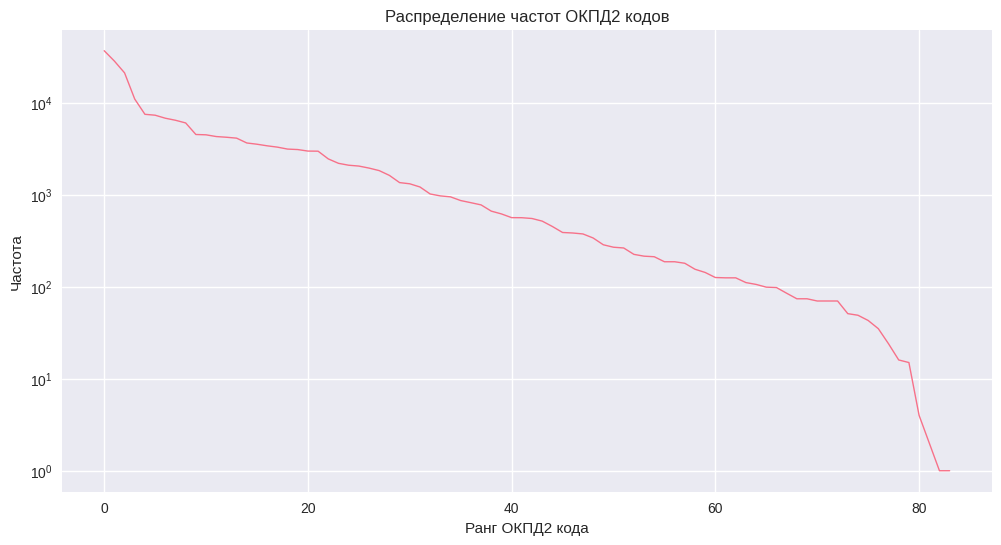

In [44]:
# Строим график распределения частот
plt.figure(figsize=(12, 6))
plt.plot(range(len(all_okpd2)), all_okpd2.values, linewidth=1)
plt.title('Распределение частот ОКПД2 кодов')
plt.xlabel('Ранг ОКПД2 кода')
plt.ylabel('Частота')
plt.grid(True)
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации


In [47]:

# Дополнительный анализ распределения
print(f"Медианная частота: {all_okpd2.median()}")
print(f"Средняя частота: {all_okpd2.mean():.2f}")
print(f"Максимальная частота: {all_okpd2.max()}")
print(f"Минимальная частота: {all_okpd2.min()}")
print(f"Стандартное отклонение: {all_okpd2.std():.2f}")


Медианная частота: 557.5
Средняя частота: 2522.46
Максимальная частота: 36805
Минимальная частота: 1
Стандартное отклонение: 5651.42


In [48]:

# Анализ долей
total_mentions = all_okpd2.sum()
top_10_percent = int(len(all_okpd2) * 0.1)
top_10_percent_share = all_okpd2.head(top_10_percent).sum() / total_mentions * 100
top_20_percent_share = all_okpd2.head(int(len(all_okpd2) * 0.2)).sum() / total_mentions * 100

print(f"На 10% самых частых кодов приходится {top_10_percent_share:.1f}% всех упоминаний")
print(f"На 20% самых частых кодов приходится {top_20_percent_share:.1f}% всех упоминаний")


На 10% самых частых кодов приходится 59.2% всех упоминаний
На 20% самых частых кодов приходится 75.6% всех упоминаний


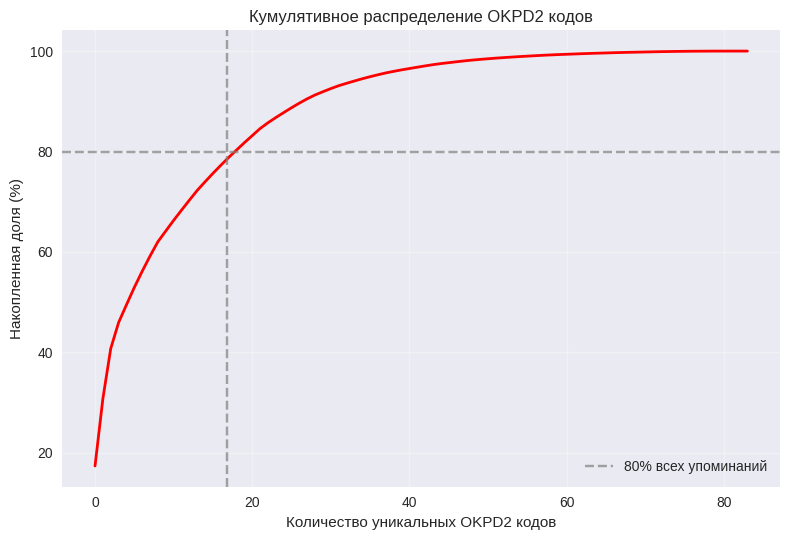

In [52]:

# Кумулятивное распределение
cumulative_share = all_okpd2.cumsum() / total_mentions * 100
plt.plot(range(len(all_okpd2)), cumulative_share, linewidth=2, color='red')
plt.title('Кумулятивное распределение OKPD2 кодов')
plt.xlabel('Количество уникальных OKPD2 кодов')
plt.ylabel('Накопленная доля (%)')
plt.grid(True, alpha=0.3)

# Добавляем ориентиры
plt.axhline(y=80, color='gray', linestyle='--', alpha=0.7, label='80% всех упоминаний')
plt.axvline(x=len(all_okpd2) * 0.2, color='gray', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60')])

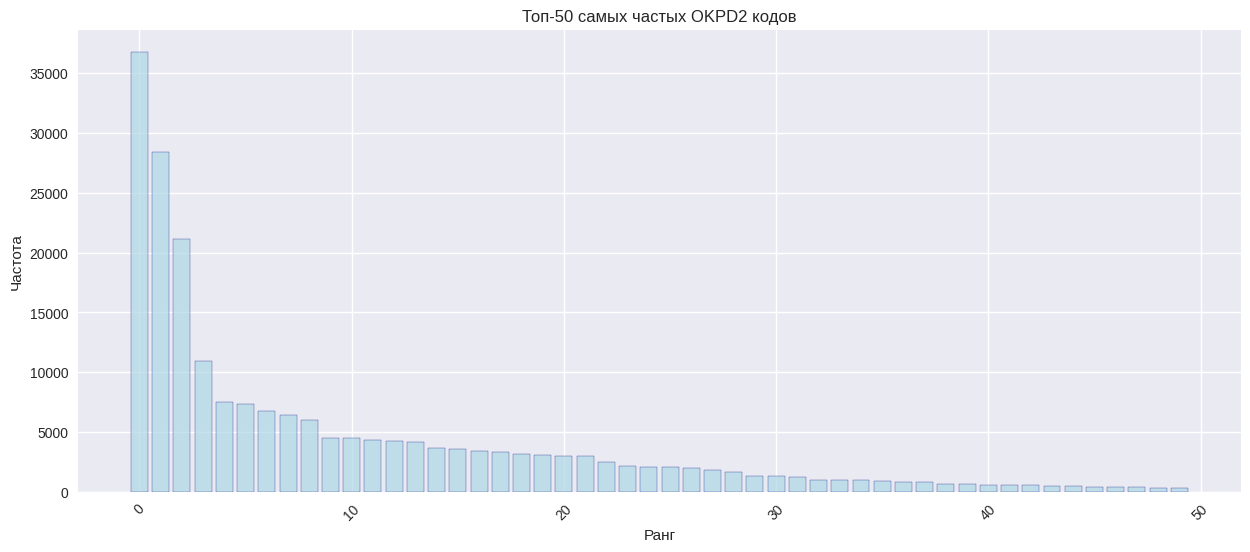

In [55]:

# Более детальный график для топ-50 кодов
plt.figure(figsize=(15, 6))
top_50 = all_okpd2.head(50)
plt.bar(range(len(top_50)), top_50.values, color='lightblue', edgecolor='navy', alpha=0.7)
plt.title('Топ-50 самых частых OKPD2 кодов')
plt.xlabel('Ранг')
plt.ylabel('Частота')
plt.xticks(rotation=45)

### Шаг 3: Предобработка текста

In [57]:
# Объединение текстовых полей
print("Длина текстов после очистки пропущенных значений:")
print(df['contractSubjectFull'].str.len().describe())

Длина текстов после очистки пропущенных значений:
count    197660.000000
mean        881.296585
std         650.372814
min         100.000000
25%         484.000000
50%         697.000000
75%        1054.000000
max        9398.000000
Name: contractSubjectFull, dtype: float64


In [58]:
# Базовая очистка текста
def clean_text(text):
    if pd.isna(text) or text == '':
        return ""
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление специальных символов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s\.]', ' ', text)
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)
    # Удаление множественных точек
    text = re.sub(r'\.{2,}', '.', text)
    return text.strip()

df['text_clean'] = df['contractSubjectFull'].apply(clean_text)

print("Пример очистки текста:")
print("ДО:", df['contractSubjectFull'].iloc[0][:200])
print("ПОСЛЕ:", df['text_clean'].iloc[0][:200])

Пример очистки текста:
ДО: 1.1. Подрядчик обязуется выполнить работы по ремонту кровли и утеплению труб жилого дома №6, расположенного по адресу: Тульская область, Ленинский район, п. Молодежный, ул. Центральная (далее - объект
ПОСЛЕ: 1.1. подрядчик обязуется выполнить работы по ремонту кровли и утеплению труб жилого дома 6 расположенного по адресу тульская область ленинский район п. молодежный ул. центральная далее объект в соотве


In [ ]:
from nltk.corpus import stopwords

# Скачивание стоп-слов
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

# Доменные стоп-слова
domain_stopwords = ['контракт', 'договор', 'приложение', 'пункт', 'статья', 
                   'далее', 'согласно', 'также', 'например', 'иной', 'другой',
                   'обязан', 'обязана', 'обязаны', 'обязано', 'условие', 'следующий',
                   'документ', 'соглашение', 'протокол', 'решение', 'акт', 'отчет']
custom_stopwords = set(russian_stopwords + domain_stopwords)

# Создаем анализатор pymorphy3
morph = pymorphy3.MorphAnalyzer()

def advanced_text_processing(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Токенизация
    tokens = text.split()
    
    # Удаление стоп-слов (приводим к нижнему регистру для сравнения)
    tokens = [token for token in tokens if token.lower() not in custom_stopwords]
    
    # Лемматизация
    lemmatized_tokens = []
    for token in tokens:
        try:
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            lemmatized_tokens.append(lemma)
        except Exception as e:
            lemmatized_tokens.append(token)
    
    return ' '.join(lemmatized_tokens)

# Применяем к данным
print("Начата продвинутая обработка текста...")
df['text_processed'] = df['contractSubjectFull'].apply(advanced_text_processing)
print("Обработка завершена!")

# Показываем результаты
print(f"\nСтатистика после обработки:")
print(f"Общее количество записей: {len(df)}")
print(f"Средняя длина исходного текста: {df['contractSubjectFull'].str.len().mean():.0f} символов")
print(f"Средняя длина обработанного текста: {df['text_processed'].str.len().mean():.0f} символов")

print("\nПример продвинутой обработки:")
for i in range(min(3, len(df))):
    print(f"\nПример {i+1}:")
    print("ДО:", df['contractSubjectFull'].iloc[i][:200] + "..." if len(df['contractSubjectFull'].iloc[i]) > 200 else df['contractSubjectFull'].iloc[i])
    print("ПОСЛЕ:", df['text_processed'].iloc[i][:200] + "..." if len(df['text_processed'].iloc[i]) > 200 else df['text_processed'].iloc[i])
    print("-" * 80)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Начата продвинутая обработка текста...


### Шаг 4: РАЗМЕТКА ДАННЫХ

In [ ]:
print("=== АНАЛИЗ СУЩЕСТВУЮЩЕЙ РАЗМЕТКИ ===")
print(f"Всего записей: {len(df)}")
print(f"Записей с OKPD2: {df['OKPD2_codes'].notna().sum()}")
print(f"Процент размеченных данных: {df['OKPD2_codes'].notna().mean():.2%}")

# Анализ структуры OKPD2 кодов
df['okpd_count'] = df['OKPD2_codes'].apply(lambda x: len(x) if x else 0)
print("\nРаспределение количества кодов OKPD2 на запись:")
print(df['okpd_count'].value_counts().sort_index())

In [ ]:
# Извлечение и нормализация целевых меток
def extract_okpd_label(okpd_codes):
    """Извлекает основной код OKPD2 для классификации"""
    if not okpd_codes or len(okpd_codes) == 0:
        return None
    
    # Берем первый код из списка
    primary_code = okpd_codes[0]
    
    # Определяем уровень детализации (начинаем с 2-значного кода)
    if len(primary_code) >= 2:
        return primary_code[:2]  # Первые 2 цифры - раздел
    else:
        return primary_code

# Создаем целевую переменную
df['target'] = df['OKPD2_codes'].apply(extract_okpd_label)

print("Уровень детализации меток:")
print(df['target'].str.len().value_counts().sort_index())

In [ ]:
# Анализ качества разметки
print("=== АНАЛИЗ КАЧЕСТВА РАЗМЕТКИ ===")

# Смотрим примеры текстов для разных классов
sample_classes = df['target'].value_counts().head(3).index

for class_label in sample_classes:
    class_texts = df[df['target'] == class_label]['text_clean'].head(2)
    print(f"\n--- Класс {class_label} ({len(df[df['target'] == class_label])} примеров) ---")
    for i, text in enumerate(class_texts):
        print(f"{i+1}. {text[:150]}...")

In [ ]:
# Обработка проблем разметки
missing_target = df['target'].isna().sum()
print(f"Записей без меток: {missing_target}")

# Анализ малочисленных классов
class_counts = df['target'].value_counts()
small_classes = class_counts[class_counts < 5]
print(f"Малочисленные классы (менее 5 примеров): {len(small_classes)}")

# Решение: удаляем записи без меток и малочисленные классы
df_labeled = df[df['target'].notna()].copy()
df_labeled = df_labeled[~df_labeled['target'].isin(small_classes.index)]

print(f"Итоговый размер размеченного датасета: {len(df_labeled)}")
print(f"Количество классов после фильтрации: {df_labeled['target'].nunique()}")

In [ ]:
# Валидация разметки
print("\n=== ВАЛИДАЦИЯ РАЗМЕТКИ (случайные примеры) ===")
sample_indices = random.sample(range(len(df_labeled)), 5)

for idx in sample_indices:
    row = df_labeled.iloc[idx]
    print(f"\nМетка: {row['target']}")
    print(f"Текст: {row['text_clean'][:200]}...")
    print("-" * 50)

### Шаг 5: Анализ размеченных данных

In [ ]:
# Статистика по классам
plt.figure(figsize=(15, 6))

# Топ-20 классов
top_classes = df_labeled['target'].value_counts().head(20)

plt.subplot(1, 2, 1)
sns.barplot(x=top_classes.values, y=top_classes.index)
plt.title('Топ-20 самых частых классов ОКПД2')
plt.xlabel('Количество примеров')

plt.subplot(1, 2, 2)
# Распределение размеров классов
class_sizes = df_labeled['target'].value_counts()
sns.histplot(class_sizes, bins=30)
plt.title('Распределение размеров классов')
plt.xlabel('Примеров в классе')

plt.tight_layout()
plt.show()

print("Статистика по классам:")
print(f"Всего классов: {len(class_sizes)}")
print(f"Медианный размер класса: {class_sizes.median()}")
print(f"Минимальный размер: {class_sizes.min()}")
print(f"Максимальный размер: {class_sizes.max()}")

In [ ]:
# Анализ длины текстов
df_labeled['text_length'] = df_labeled['text_processed'].str.split().str.len()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df_labeled, x='text_length', bins=50)
plt.title('Общее распределение длины текстов')
plt.xlabel('Длина текста (слов)')

plt.subplot(1, 2, 2)
# Длина текста по топ-10 классам
top_10_classes = class_sizes.head(10).index
df_top_classes = df_labeled[df_labeled['target'].isin(top_10_classes)]
sns.boxplot(data=df_top_classes, x='target', y='text_length')
plt.title('Длина текста по классам (топ-10)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Статистика длины текстов:")
print(df_labeled['text_length'].describe())

### Шаг 6: Разделение на выборки

In [ ]:
from sklearn.model_selection import train_test_split

# Стратифицированное разделение
X = df_labeled['text_processed']
y = df_labeled['target']

# 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print("=== РАЗДЕЛЕНИЕ НА ВЫБОРКИ ===")
print(f"Обучающая выборка: {len(X_train)} записей ({len(X_train)/len(X):.1%})")
print(f"Валидационная выборка: {len(X_val)} записей ({len(X_val)/len(X):.1%})")
print(f"Тестовая выборка: {len(X_test)} записей ({len(X_test)/len(X):.1%})")

# Проверяем распределение классов в выборках
print("\nРаспределение классов по выборкам:")
for name, split in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f"{name}: {split.nunique()} классов")

### Шаг 7: Векторизация текста

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# TF-IDF с разными настройками
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Учитываем отдельные слова и пары
    min_df=2,           # Игнорируем очень редкие слова
    max_df=0.9,         # Игнорируем очень частые слова
    stop_words=list(custom_stopwords)
)

# Bag-of-Words для сравнения
bow_vectorizer = CountVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    stop_words=list(custom_stopwords)
)

print("Векторизаторы созданы")

In [ ]:
# TF-IDF
print("Векторизация TF-IDF...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Bag-of-Words
print("Векторизация Bag-of-Words...")
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"\nРазмерности матриц признаков:")
print(f"TF-IDF: {X_train_tfidf.shape}")
print(f"BOW: {X_train_bow.shape}")

# Сохранение processed данных
df_processed = pd.DataFrame({
    'text_processed': X,
    'target': y
})
df_processed.to_csv('processed_contracts_data.csv', index=False)
print("\nОбработанные данные сохранены в 'processed_contracts_data.csv'")

---
# Чекпойнт №3: Применение простых моделей

### Шаг 1: Определение метрик качества

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

# Для многоклассовой классификации с дисбалансом
key_metric = 'f1_macro'  # F1-score (macro average)

def evaluate_model(y_true, y_pred, model_name):
    """Полная оценка модели"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    
    print(f"=== {model_name} ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics

### Шаг 2: Baseline-модели

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

print("=== BASELINE МОДЕЛИ ===")

# KNN
print("\nОбучение KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)
y_pred_knn = knn.predict(X_val_tfidf)
knn_metrics = evaluate_model(y_val, y_pred_knn, "KNN")

# Logistic Regression
print("\nОбучение Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_val_tfidf)
lr_metrics = evaluate_model(y_val, y_pred_lr, "Logistic Regression")

# Naive Bayes
print("\nОбучение Naive Bayes...")
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)
y_pred_nb = nb.predict(X_val_bow)
nb_metrics = evaluate_model(y_val, y_pred_nb, "Naive Bayes")

### Шаг 3: Подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

print("=== ПОДБОР ГИПЕРПАРАМЕТРОВ ===")

# Оптимизация логистической регрессии
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2', 'none'],
    'class_weight': [None, 'balanced']
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'),
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

print("Запуск GridSearch...")
lr_grid.fit(X_train_tfidf, y_train)

print(f"Лучшие параметры: {lr_grid.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {lr_grid.best_score_:.4f}")

### Шаг 4: Анализ результатов

In [ ]:
# Тестирование лучшей модели
best_model = lr_grid.best_estimator_
y_pred_best = best_model.predict(X_val_tfidf)
best_metrics = evaluate_model(y_val, y_pred_best, "Best Logistic Regression")

# Сравнение всех моделей
print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
models_comparison = pd.DataFrame({
    'KNN': knn_metrics,
    'LogisticRegression': lr_metrics,
    'NaiveBayes': nb_metrics,
    'BestModel': best_metrics
})

models_comparison

In [ ]:
# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))

metrics_to_plot = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
models_comparison.T[metrics_to_plot].plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение метрик моделей')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Матрица ошибок лучшей модели
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_val, y_pred_best, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, ax=plt.gca())
plt.title('Матрица ошибок - Best Logistic Regression')
plt.tight_layout()
plt.show()

In [ ]:
# Анализ самых частых ошибок
error_analysis = pd.DataFrame({
    'true': y_val,
    'predicted': y_pred_best,
    'text': X_val
})

errors = error_analysis[y_val != y_pred_best]
error_counts = errors.groupby(['true', 'predicted']).size().reset_index(name='count')
error_counts = error_counts.sort_values('count', ascending=False)

print("Самые частые ошибки классификации:")
print(error_counts.head(10))

print("\nПримеры ошибок:")
for i in range(min(3, len(errors))):
    row = errors.iloc[i]
    print(f"\nОшибка {i+1}:")
    print(f"Истинный класс: {row['true']}")
    print(f"Предсказанный класс: {row['predicted']}")
    print(f"Текст: {row['text'][:200]}...")

### Шаг 5: Финальные выводы

In [ ]:
print("=== ФИНАЛЬНЫЕ ВЫВОДЫ ===")

print(f"1. РАЗМЕТКА ДАННЫХ:")
print(f"   - Исходный датасет: {len(df)} записей")
print(f"   - После очистки и разметки: {len(df_labeled)} записей")
print(f"   - Количество классов: {df_labeled['target'].nunique()}")
print(f"   - Сбалансированность: медианный размер класса {class_sizes.median()}")

print(f"\n2. КАЧЕСТВО МОДЕЛЕЙ (F1-macro):")
print(f"   - KNN: {knn_metrics['f1_macro']:.4f}")
print(f"   - Naive Bayes: {nb_metrics['f1_macro']:.4f}")
print(f"   - Logistic Regression: {lr_metrics['f1_macro']:.4f}")
print(f"   - Best Model: {best_metrics['f1_macro']:.4f}")

print(f"\n3. РЕКОМЕНДАЦИИ:")
print(f"   - Лучшая модель: {type(best_model).__name__}")
print(f"   - Ключевая метрика: {key_metric}")
print(f"   - Основные проблемы: дисбаланс классов, семантически близкие классы")

# Сохранение лучшей модели
import joblib

model_artifacts = {
    'model': best_model,
    'vectorizer': tfidf_vectorizer,
    'metrics': best_metrics
}

joblib.dump(model_artifacts, 'best_model_artifacts.pkl')
print(f"\nЛучшая модель сохранена в 'best_model_artifacts.pkl'")